In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


from general_code import *

In [3]:
# define data path
data_folder = '../Data/'

In [4]:
# read the data
data = pd.read_csv(data_folder +'result_full_factorial_pgm.zip', index_col = 0)
data.drop('Unnamed: 0.1', axis=1, inplace=True)
data.head()

,enzyme_complex_concentration,enzyme_concentration,k1_bwd_effective,k1_bwd_relative,k1_fwd_effective,k1_fwd_relative,k2_bwd_effective,k2_bwd_relative,k2_fwd_effective,k2_fwd_relative,mu_mass,product_concentration,realization,sigma_mass,substrate_concentration,volume_fraction
0,0.000058,0.000006,4.503135,0.450314,262554.802451,1.723016,7.139138e+05,2.164051,9.907347,0.450334,12.1,0.000098,2.0,0.000,0.000049,0.2
1,0.000006,0.000058,4.491493,0.449149,285144.598410,1.871261,6.227429e+05,1.887689,9.879449,0.449066,12.1,0.000147,3.0,0.000,0.000245,0.2
2,0.000019,0.000045,7.636543,0.763654,262351.891789,1.721684,6.597299e+05,1.999806,16.799770,0.763626,31.9,0.000016,5.0,0.825,0.000024,0.2
3,0.000013,0.000051,0.634308,0.063431,484409.307429,3.178936,1.063666e+06,3.224238,1.395557,0.063434,12.1,0.000196,8.0,0.000,0.000012,0.4
4,0.000006,0.000058,4.416002,0.441600,281281.994713,1.845913,5.871605e+05,1.779830,9.719614,0.441801,12.1,0.000049,4.0,0.000,0.000147,0.2


In [5]:
y1, y2, y3, y4 = np.log(data['k1_bwd_effective']), np.log(data['k1_fwd_effective']), np.log(data['k2_bwd_effective']), np.log(data['k2_fwd_effective'])

X = data.drop(columns=['k1_bwd_effective','k1_fwd_effective','k2_bwd_effective','k2_fwd_effective',
                  'k1_bwd_relative','k1_fwd_relative','k2_bwd_relative','k2_fwd_relative', 'realization'])

X = cast_categories(X, 'sigma_mass', 'sigma_mass')
# X.head()

# Plots

Seems useless, nothing to see

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("whitegrid")


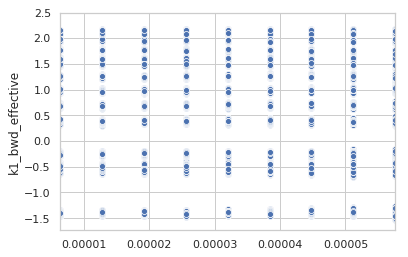

In [62]:
plt.xlim(X['enzyme_concentration'].min(), X['enzyme_concentration'].max())
sns.scatterplot(x=(X['enzyme_concentration']*X['sigma_mass_0.0']), y=y1)

# Data engineering

In [6]:
X[['enzyme_complex_concentration', 'enzyme_concentration', 'product_concentration',
       'substrate_concentration']] = X[['enzyme_complex_concentration', 'enzyme_concentration', 'product_concentration',
       'substrate_concentration']].apply(lambda x : np.log(x))
X.head()

,enzyme_complex_concentration,enzyme_concentration,mu_mass,product_concentration,substrate_concentration,volume_fraction,sigma_mass_0.0,sigma_mass_0.825
0,-9.761988,-11.959213,12.1,-9.230543,-9.923690,0.2,1,0
1,-11.959213,-9.761988,12.1,-8.825078,-8.314252,0.2,1,0
2,-10.860600,-10.013302,31.9,-11.022305,-10.616837,0.2,0,1
3,-11.266065,-9.879771,12.1,-8.537396,-11.309985,0.4,1,0
4,-11.959213,-9.761988,12.1,-9.923690,-8.825078,0.2,1,0


### Interactions w/o categories

In [15]:
X1 = X[['enzyme_complex_concentration', 'enzyme_concentration', 'mu_mass', 'product_concentration',
       'substrate_concentration', 'volume_fraction']].values
X2 = X[['sigma_mass_0.0', 'sigma_mass_0.825']].values

In [16]:
poly = PolynomialFeatures(2, interaction_only=True)
X = np.concatenate((poly.fit_transform(X1), X2), axis=1)
print(X.shape)

(151956, 24)


### Interaction w/ categories
works better. Best performance: _Degree 2 complete_

In [7]:
poly = PolynomialFeatures(2, interaction_only=False)
X = poly.fit_transform(X.values)
print(X.shape)

(151956, 45)


# Regressions

## Ridge

### Train test splitting

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y1, random_state=0, test_size=0.4)
print(X_train.shape, X_test.shape)

(91173, 45) (60783, 45)


### Fitting

In [9]:
ridge_reg = RidgeCV(alphas=np.logspace(-5,5,40), fit_intercept=False).fit(X_train, y_train)

print('Train R^2 score : ', ridge_reg.score(X_train, y_train), '\n',
     'Test R^2 score : ', ridge_reg.score(X_test, y_test))

Train R^2 score :  0.9883379072811995 
 Test R^2 score :  0.9882807377522616


In [10]:
y_pred_tr = ridge_reg.predict(X_train)
y_pred_te = ridge_reg.predict(X_test)

print()
print('MSE on train : ', mean_squared_error(y_train, y_pred_tr), '\n',
     'MSE on test : ', mean_squared_error(y_test, y_pred_te))


MSE on train :  0.012969698643216673 
 MSE on test :  0.013082949299602369


In [12]:
print('alpha : ', ridge_reg.alpha_,'\n',
     'Coeff : ', ridge_reg.coef_)

alpha :  0.003665241237079626 
 Coeff :  [ 1.40099101e-02 -7.03980994e-02 -3.92428024e-02  5.02744229e-02
 -4.51612149e-02 -4.91458286e-02 -1.44835325e+00  1.31997844e-02
  8.10125627e-04  8.17234446e-04 -1.41009590e-02 -1.01627469e-04
  1.83142034e-04 -1.88953448e-04 -3.11658506e-03 -3.51916379e-02
 -3.52064617e-02  3.02798060e-03 -1.45337722e-04  4.10709773e-04
 -4.27640060e-04  6.83188972e-03 -2.11970139e-02 -1.80457878e-02
 -1.60080405e-03  4.07090122e-05 -2.27312648e-05  1.11969489e-01
  2.44314134e-02  2.58430079e-02 -3.49407711e-03 -1.82472524e-04
 -1.87094169e-02 -2.26375752e-02 -2.25236390e-02 -3.27078944e-03
 -1.64966589e-02 -2.59135698e-02 -2.32322581e-02 -1.23393055e+01
 -1.11338067e+00 -3.34972584e-01  1.31997844e-02  0.00000000e+00
  8.10125606e-04]


In [14]:
from sklearn import feature_selection

In [18]:
selection = feature_selection.RFE(ridge_reg).fit(X_train, y_train)

y_pred_tr = selection.predict(X_train)
y_pred_te = selection.predict(X_test)

print()
print('MSE on train : ', mean_squared_error(y_train, y_pred_tr), '\n',
     'MSE on test : ', mean_squared_error(y_test, y_pred_te))



MSE on train :  0.020192404150460377 
 MSE on test :  0.020208736121843072


## Support vector regression

### Train test splitting

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y1, random_state=0, test_size=0.4)
print(X_train.shape, X_test.shape)

(91173, 8) (60783, 8)


### Fitting

In [ ]:
svm_reg = SVR(kernel='poly', degree=2).fit(X_train,y_train)

print('Train R^2 score : ', svm_reg.score(X_train, y_train), '\n',
     'Test R^2 score : ', svm_reg.score(X_test, y_test))

In [ ]:
y_pred_tr = svm_reg.predict(X_train)
y_pred_te = svm_reg.predict(X_test)

print()
print('MSE on train : ', mean_squared_error(y_train, y_pred_tr), '\n',
     'MSE on test : ', mean_squared_error(y_test, y_pred_te))

# Tests

In [27]:
df = pd.DataFrame({'a' : 4*[1]+4*[2]+4*[3],
                  'b' : 3*[4,5,6,7]},
                 index = list(range(12)))
df

,a,b
0,1,4
1,1,5
2,1,6
3,1,7
4,2,4
5,2,5
6,2,6
7,2,7
8,3,4
9,3,5


In [28]:
cond = True
[1 if x else 0 for x in df['a']==1]

[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]

In [32]:
cast_categories(df, 'a', cat_name='Number')

,b,Number 1,Number 2,Number 3
0,4,1,0,0
1,5,1,0,0
2,6,1,0,0
3,7,1,0,0
4,4,0,1,0
5,5,0,1,0
6,6,0,1,0
7,7,0,1,0
8,4,0,0,1
9,5,0,0,1
